In [1]:
#Setup


In [2]:
from dataclasses import dataclass
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, ndimage
from skimage import transform
from sklearn.datasets import fetch_openml
from tqdm import tqdm

In [3]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=True)

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
#X = X[:1000]
#y = y[:1000]
X.shape

(70000, 784)

In [6]:
X /= 255.0
X = X[:10000]

In [29]:
def qrsvd(X, *, save=False, load=False, file_suffix=None, return_all=False):
    """
    Parameters
    ----------
    X : array-like
        The matrix to decompose.
    save : bool, default=True
        Whether to save the Q, R, U, s, and Vh matrices to disk.
    load : bool, default=True
        Whether to load the Q, R, U, s, and Vh matrices from disk if they exist.
    file_suffix : str, default=""
        The suffix to append to the file names if saving or loading. An underscore
        will be prepended to the suffix if it is given.
    return_all : bool, default=False
        Whether to return all of the matrices or just the singular values.
    """
    file_suffix = "" if file_suffix is None else f"_{file_suffix}"
    # These are separate try/except blocks so that if the QR decomposition succeeds
    # but the SVD fails, we don't have to recompute the QR decomposition.
    try:
        if not load:
            raise OSError
        Q = np.load(f"Q{file_suffix}.npy")
        R = np.load(f"R{file_suffix}.npy")
    except OSError:
        Q, R = linalg.qr(X)
        if save:
            np.save(f"Q{file_suffix}.npy", Q)
            np.save(f"R{file_suffix}.npy", R)

    try:
        if not load:
            raise OSError
        U = np.load(f"U{file_suffix}.npy")
        s = np.load(f"s{file_suffix}.npy")
        Vh = np.load(f"Vh{file_suffix}.npy")
    except OSError:
        U, s, Vh = linalg.svd(R)
        if save:
            np.save(f"U{file_suffix}.npy", U)
            np.save(f"s{file_suffix}.npy", s)
            np.save(f"Vh{file_suffix}.npy", Vh)

    return (Q, U, s, Vh) if return_all else s

In [30]:
s = qrsvd(X)

In [39]:
figsize = (13.33, 7.5)
dpi = 96
tick_labelsize = 16
linewidths = 4
label_fontsize = 20
title_fontsize = 24

In [40]:
def plot_singular_values(*s_list, labels=None, title:str=None, save=False):
    """Plot the singular values of the given matrices."""
    plt.figure(figsize=figsize, dpi=dpi)
    plt.tick_params(labelsize=tick_labelsize)
    plt.xlabel("Index", fontsize=label_fontsize)
    plt.ylabel("Log of Singular Value", fontsize=label_fontsize)
    if title is not None:
        plt.title(title, fontsize=title_fontsize)
    for s in s_list:
        plt.scatter(np.arange(len(s)), np.log(s), linewidths=linewidths)
    if labels is not None:
        plt.legend(labels, fontsize=label_fontsize)
    plt.tight_layout()
    if save:
        plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

## k-means grouping

In [7]:
def twodim(vec, dim):
    result = []
    i = 1
    while i * dim <= len(vec):
        result = result + [vec[(i - 1)*dim:i*dim]]
        i = i + 1
    return result
x = [1, 2, 3, 4]
twodim(x, 2)

[[1, 2], [3, 4]]

In [8]:
from scipy import ndimage
import numpy as np
print(ndimage.center_of_mass(np.array(twodim(X[1], 28)))[0])
X = X[:10000]
print(X.shape)
ComX = []
for elem in X:
    ComX = ComX + [[ndimage.center_of_mass(np.array(twodim(elem, 28)))[0], ndimage.center_of_mass(np.array(twodim(elem, 28)))[1]]]
ComX = np.array(ComX)

13.553304422145679
(10000, 784)


In [9]:
def initialize_random_centroids(K, X):
    """Initializes and returns k random centroids"""
    m, n = np.shape(X)
    # a centroid should be of shape (1, n), so the centroids array will be of shape (K, n)
    centroids = np.empty((K, n))
    for i in range(K):
        # pick a random data point from X as the centroid
        centroids[i] =  X[np.random.choice(range(m))] 
    return centroids

def closest_centroid(x, centroids, K):
    """Finds and returns the index of the closest centroid for a given vector x"""
    distances = np.empty(K)
    for i in range(K):
        distances[i] = euclidean_distance(centroids[i], x)
    return np.argmin(distances) # return the index of the lowest distance

def create_clusters(centroids, K, X):
    """Returns an array of cluster indices for all the data samples"""
    m, _ = np.shape(X)
    cluster_idx = np.empty(m)
    for i in range(m):
        cluster_idx[i] = closest_centroid(X[i], centroids, K)
    return cluster_idx

def compute_means(cluster_idx, K, X):
    """Computes and returns the new centroids of the clusters"""
    _, n = np.shape(X)
    centroids = np.empty((K, n))
    for i in range(K):
        points = X[cluster_idx == i] # gather points for the cluster i
        centroids[i] = np.mean(points, axis=0) # use axis=0 to compute means across points
    return centroids

def run_Kmeans(K, X, max_iterations=500):
    """Runs the K-means algorithm and computes the final clusters"""
    # initialize random centroids
    centroids = initialize_random_centroids(K, X)
    # loop till max_iterations or convergance
    print(f"initial centroids: {centroids}")
    for _ in range(max_iterations):
        # create clusters by assigning the samples to the closet centroids
        clusters = create_clusters(centroids, K, X)
        previous_centroids = centroids                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
        # compute means of the clusters and assign to centroids
        centroids = compute_means(clusters, K, X)
        # if the new_centroids are the same as the old centroids, return clusters
        diff = previous_centroids - centroids
        if not diff.any():
            return clusters
    return clusters

def euclidean_distance(x1, x2):
    """Calculates and returns the euclidean distance between two vectors x1 and x2"""
    return np.sqrt(np.sum(np.power(x1 - x2, 2)))


#its all from https://dev.to/sajal2692/coding-k-means-clustering-using-python-and-numpy-fg1 this guy

In [10]:
testData = [[1, 2], [3, 4], [5, 6]]
#print(ComX)
Xkmeans = run_Kmeans(10, ComX)


initial centroids: [[13.55478933 13.58224633]
 [14.38007961 13.55522298]
 [13.61730225 13.76119377]
 [14.40739227 13.66530338]
 [13.91289479 13.93720789]
 [13.74016655 14.33011955]
 [14.12469549 13.91661706]
 [13.53492214 14.22683125]
 [13.89787702 13.94612898]
 [14.35147307 14.22198509]]


initial centroids: [[ 4.11011863  2.48643712]
 [-3.34841515  8.70507375]
 [-5.72103161 -7.70079191]]


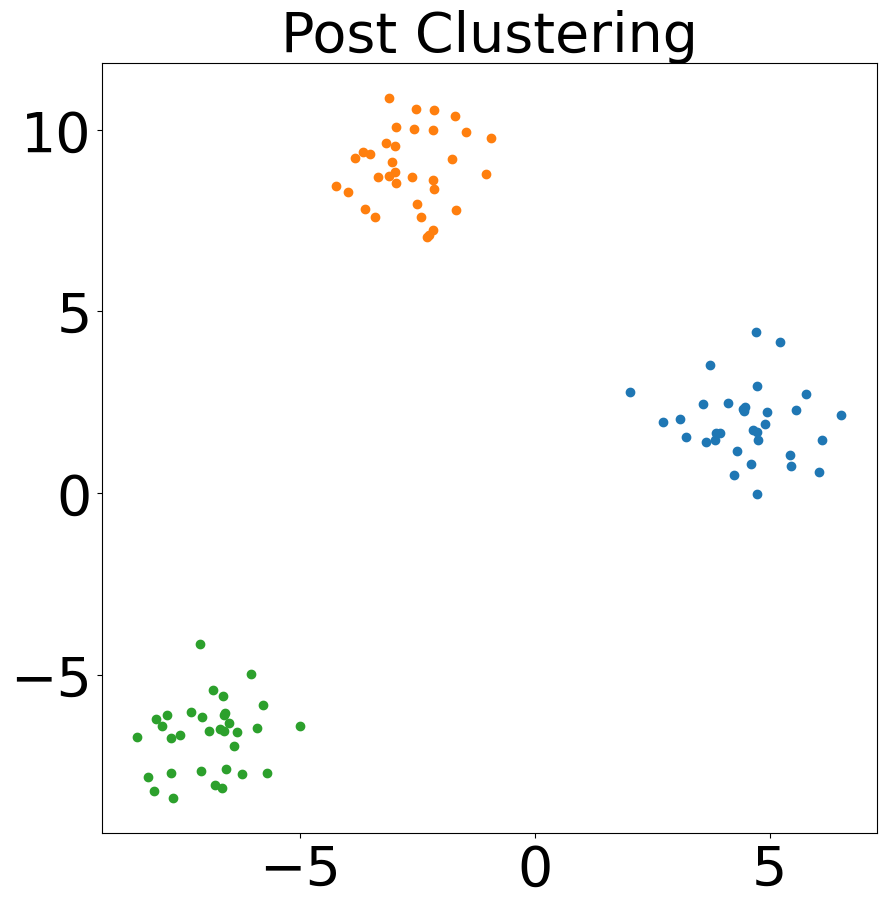

In [11]:
np.random.seed(42)
from sklearn import datasets
# creating a dataset for clustering
datX, y = datasets.make_blobs()
y_preds = run_Kmeans(3, datX, 10000)

plt.figure(figsize=(10,10))
plt.title('Post Clustering', fontsize = 40)
plt.tick_params(labelsize=40)

for i in range(3):
    xs = []
    ys = []
    for j in range(len(datX)):
        if y_preds[j] == i:
            
            xs = xs + [datX[j][0]]
            ys = ys + [datX[j][1]]
    plt.scatter(xs, ys)

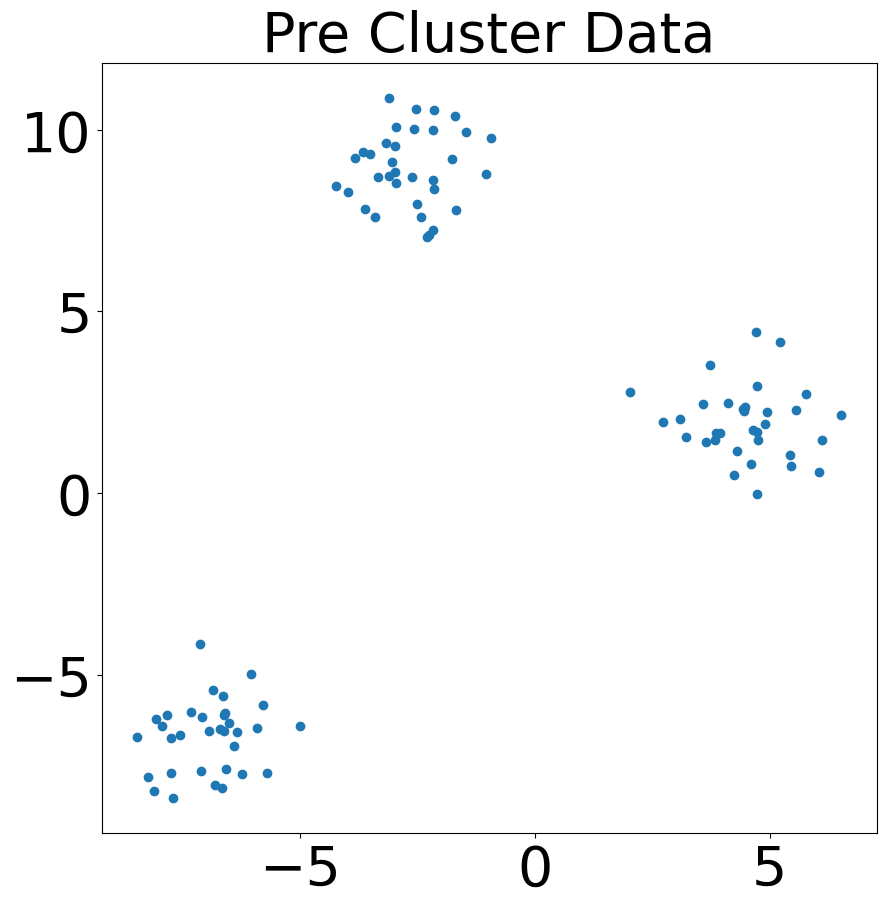

In [12]:
np.random.seed(42)
plt.figure(figsize=(10,10))
plt.title('Pre Cluster Data', fontsize = 40)
plt.tick_params(labelsize=40)

xs = []
ys = []
for elem in datX:
    xs = xs + [elem[0]]
    ys = ys + [elem[1]]


plt.scatter(xs, ys)

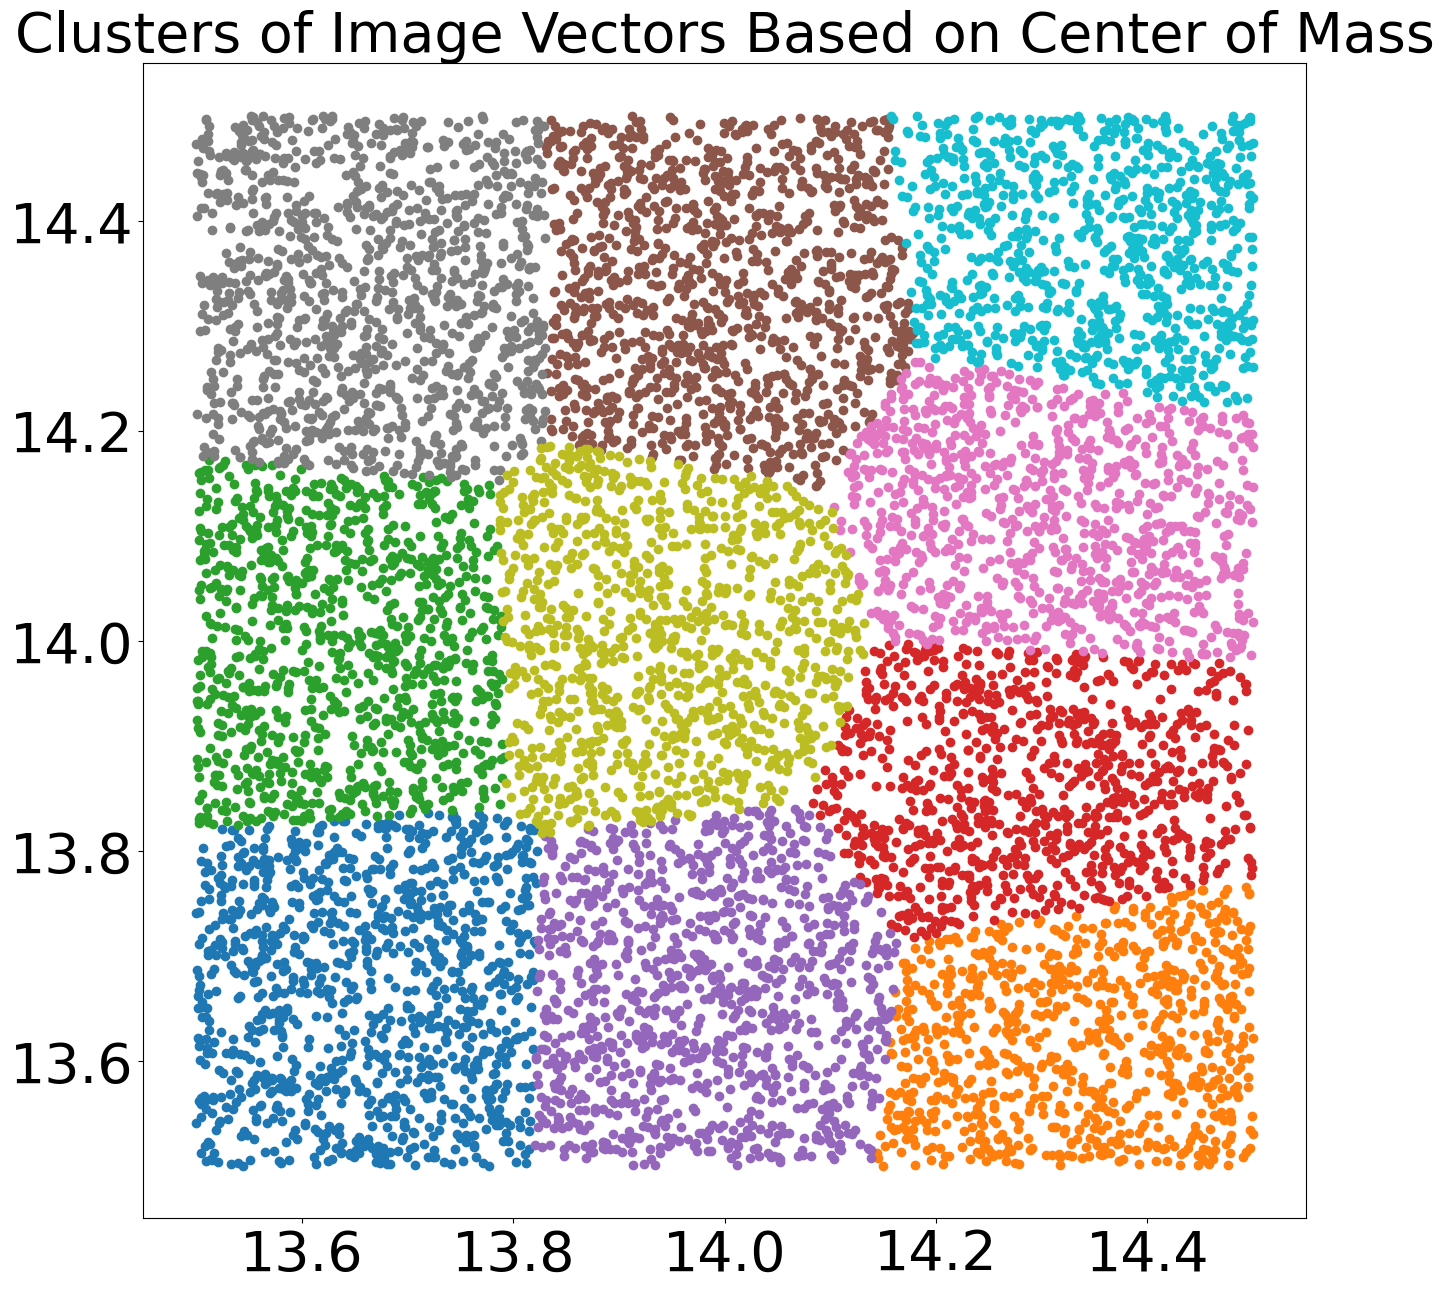

In [13]:
plt.figure(figsize=(15,15))


for i in range(10):
    xs = []
    ys = []
    for j in range(len(ComX)):
        if Xkmeans[j] == i:
            
            xs = xs + [ComX[j][0]]
            ys = ys + [ComX[j][1]]
    plt.scatter(xs, ys)
    

plt.title('Clusters of Image Vectors Based on Center of Mass', fontsize = 40)
plt.tick_params(labelsize=40)

In [16]:
# modified code, original source: https://stackoverflow.com/questions/31400769/bounding-box-of-numpy-array
def find_bbox(img):
    img = np.where(img>0.3, img, 0)
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax+1, cmin, cmax+1


In [17]:
#def bbox_coords(imgs):
    #imgs_recentered = np.zeros_like(imgs)
    #result = []
    #for i, img in tqdm(enumerate(imgs)):
        #img = img.reshape(28,28)
        #rmin, rmax, cmin, cmax = find_bbox(img)
        #bbox_center = ((rmin + rmax)/2,  (cmin + cmax)/2)
        #result = result + bbox_center
    #return result

In [18]:

def bbox_coords(imgs):
    imgs_recentered = np.zeros_like(imgs)
    result = []
    for i, img in tqdm(enumerate(imgs)):
        img = img.reshape(28,28)
        rmin, rmax, cmin, cmax = find_bbox(img) 
        result = result + [[rmax-rmin, cmax-cmin]]
    return result


Xbbox = bbox_coords(X)

10000it [00:00, 22362.56it/s]


initial centroids: [[20. 16.]
 [20. 20.]
 [20. 16.]
 [20. 14.]
 [20. 17.]
 [20. 12.]
 [17. 20.]
 [20. 15.]
 [20. 12.]
 [20. 20.]]
[1. 1. 1. ... 1. 1. 1.]


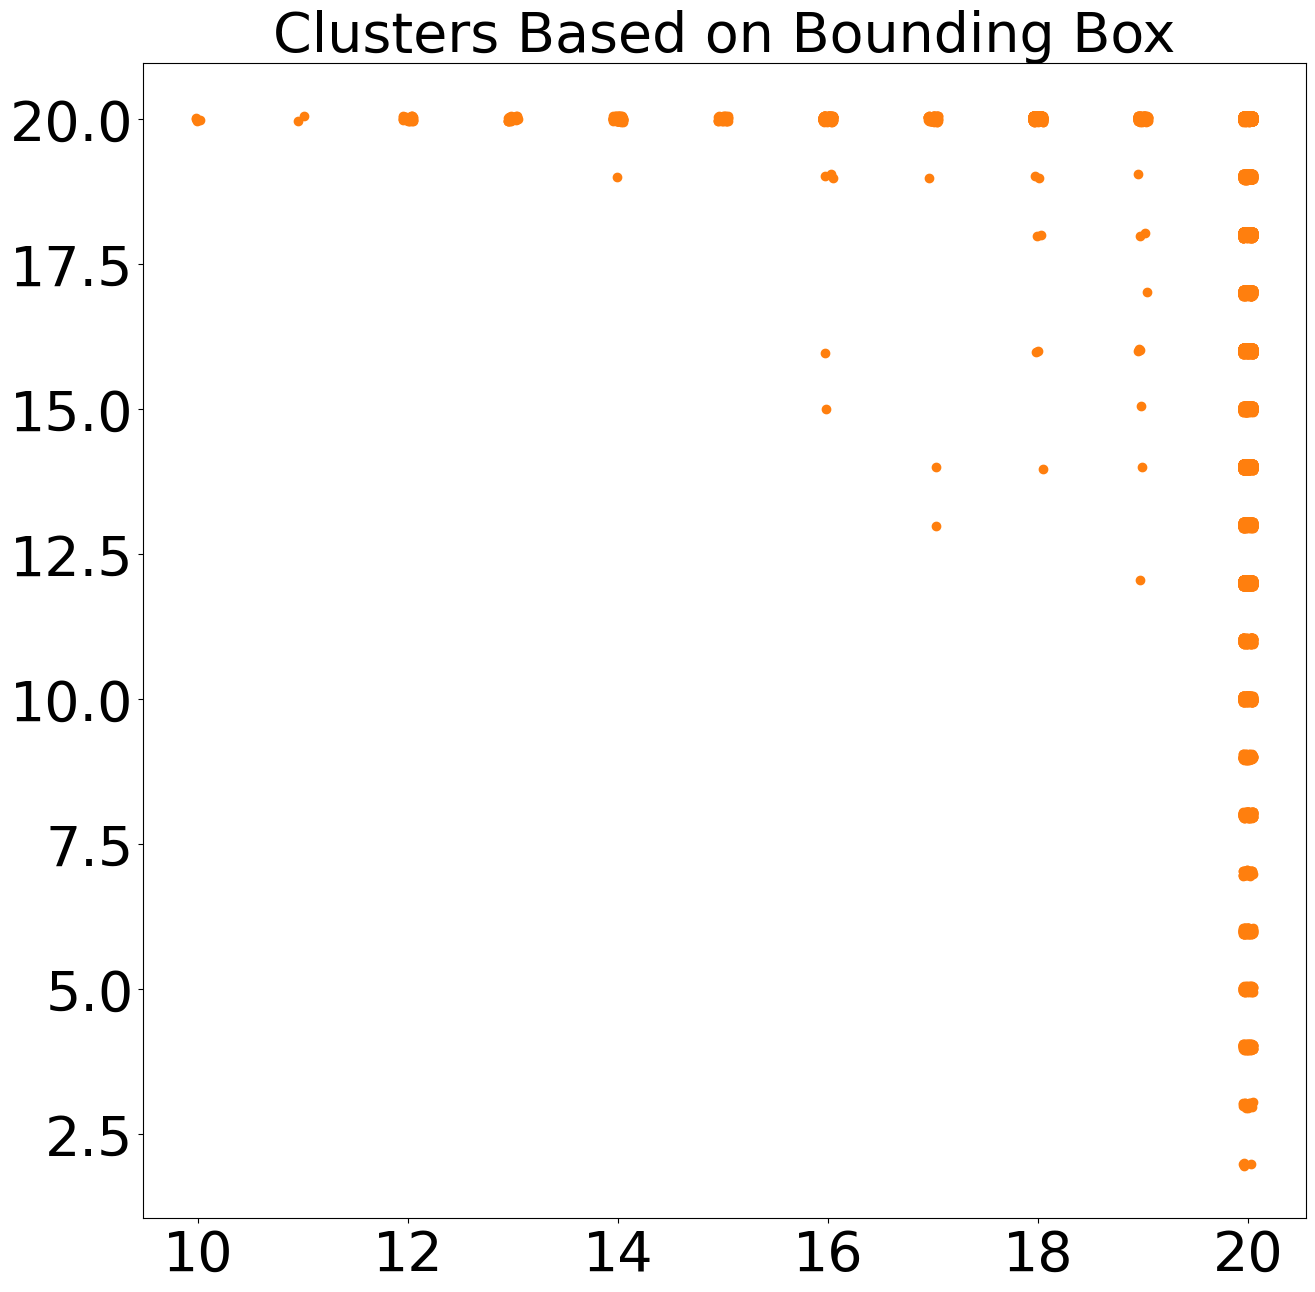

In [20]:
plt.figure(figsize=(15,15))

Xbbox = np.array(Xbbox)

Xbboxkmeans = run_Kmeans(10, np.array(Xbbox))
print(Xbboxkmeans)

for i in range(10):
    xs = []
    ys = []
    for j in range(len(Xbbox)):
        if Xbboxkmeans[j] == i:
            
            xs = xs + [Xbbox[j][0] + (np.random.rand() - 0.5)*0.1]
            ys = ys + [Xbbox[j][1] + (np.random.rand() - 0.5)*0.1]
    plt.scatter(xs, ys)

plt.title('Clusters Based on Bounding Box', fontsize = 40)
plt.tick_params(labelsize=40)

In [23]:
X3 = []
for i in range(len(X)):
    X3 = X3 + [np.append(X[i], [Xkmeans[i]])]
X3 = np.array(X3)

In [24]:
Q3, R3 = linalg.qr(X3)
U3, s3, Vh3 = linalg.svd(R3)

In [26]:
X4 = []
for i in range(len(X)):
    X4 = X4 + [np.append(X[i], [Xbbox[i][0], Xbbox[i][1]])]
X4 = np.array(X4)

In [32]:
Q4, R4 = linalg.qr(X4)
U4, s4, Vh4 = linalg.svd(R4)

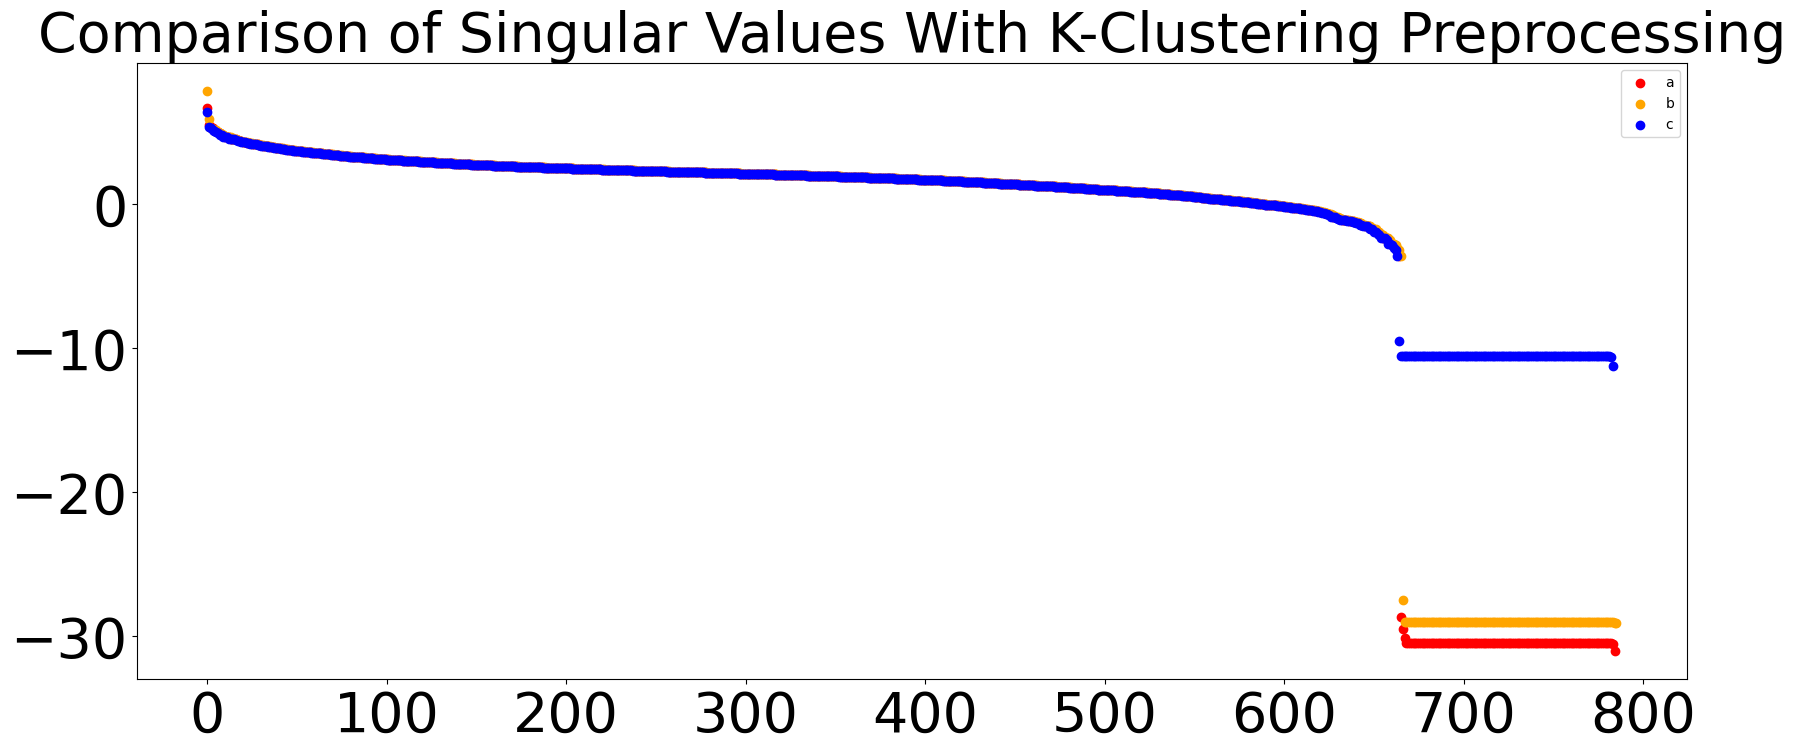

In [36]:
plt.figure(figsize=(20,8))
a = plt.scatter(np.arange(0,785), np.log(s3), color = 'red')
b = plt.scatter(np.arange(0,786), np.log(s4), color = 'orange')
c = plt.scatter(np.arange(0,784), np.log(s), color = 'blue')
plt.legend(["a", "b", "c"])
plt.title('Comparison of Singular Values With K-Clustering Preprocessing', fontsize = 40)
plt.tick_params(labelsize=40)


In [37]:
#So i didn't do kcluster with the features of the image as the dimensions, the runtime, even with max settings on idas, would be literally hours if not days. 

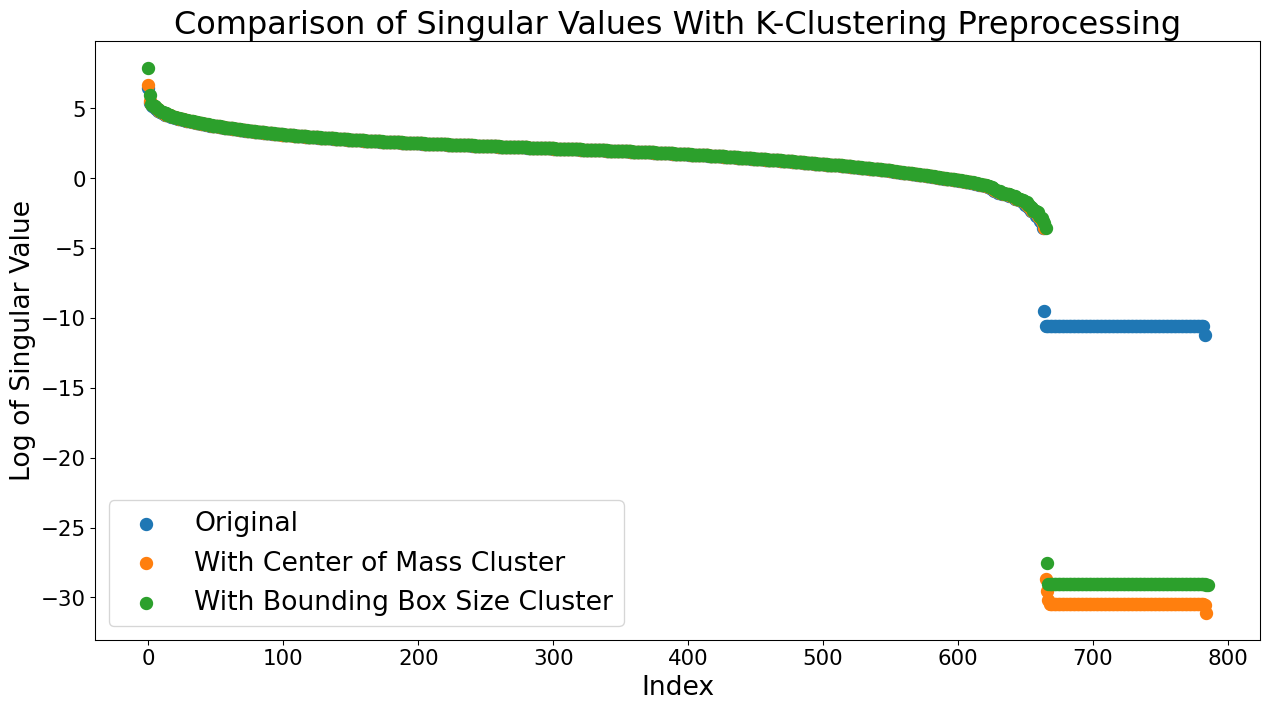

In [41]:
plot_singular_values(
    s, s3, s4,
    labels=["Original", "With Center of Mass Cluster", "With Bounding Box Size Cluster"],
    title="Comparison of Singular Values With K-Clustering Preprocessing",
    save=True,
)

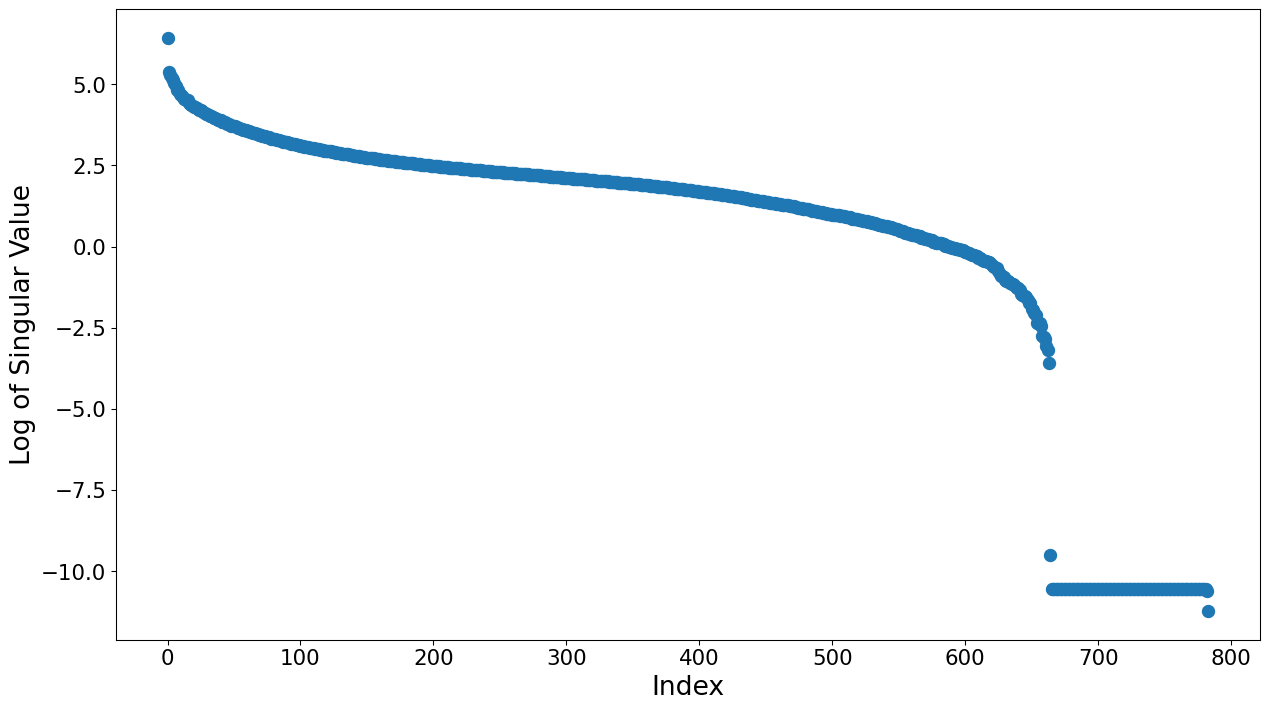

In [42]:
plot_singular_values(s)